# Feature engineering and model training for E4-MET

In [72]:

import pandas as pd
import os 

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.signal import find_peaks
import numpy as np

os.chdir("C:\\Users\\TipeJ\\Documents\\Projects\\DataMiningProject")
pd.set_option("display.precision", 2)

In [73]:
# Load the data from the pickle files
participants_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']
X_columns = ["X", "Y", "Z", "Magnitude"]
merged_dataset = [pd.read_pickle("merged_dataset/{0}/E4.pkl".format(participant)) for participant in participants_list]
# Add participant to the dataset
for i in range(len(participants_list)):
    merged_dataset[i]['Participant'] = participants_list[i]
merged_dataset[0]

,Time[s],Delta_Time,MET,X,Y,Z,Magnitude,Participant
0,1.0,0 days 00:00:00,1.31,30.0,0.0,55.67,63.24,P1
1,2.0,0 days 00:00:01,1.31,30.0,0.0,55.75,63.31,P1
2,3.0,0 days 00:00:02,1.52,30.0,0.0,55.80,63.35,P1
3,4.0,0 days 00:00:03,1.63,30.0,0.0,55.60,63.18,P1
4,5.0,0 days 00:00:04,1.56,30.0,0.0,55.80,63.35,P1
...,...,...,...,...,...,...,...,...
1797,1798.0,0 days 00:29:57,5.32,20.2,-49.4,36.00,64.38,P1
1798,1799.0,0 days 00:29:58,5.11,18.0,-50.2,33.80,63.14,P1
1799,1800.0,0 days 00:29:59,4.46,17.8,-50.2,34.20,63.30,P1
1800,1801.0,0 days 00:30:00,4.12,15.2,-49.4,36.20,63.10,P1


## Options

In [74]:
include_time_lagged_features = True
include_statistical_features = True
statistical_features_roll_window = 10
activity_split = False

## Feature engineering

### Time lagged features

In [75]:
# Time lagged feature generation for ACC data
def time_lagged_features(data, time_lags):
    for time_lag in time_lags:
        data['X_lag_b_{}'.format(time_lag)] = data['X'].shift(time_lag)
        data['Y_lag_b_{}'.format(time_lag)] = data['Y'].shift(time_lag)
        data['Z_lag_b_{}'.format(time_lag)] = data['Z'].shift(time_lag)
        # Backward fill the missing values
        data['X_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)
        data['Y_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)
        data['Z_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)

        # # Now create the forward lagged features
        # data['X_lag_f_{}'.format(time_lag)] = data['X'].shift(-time_lag)
        # data['Y_lag_f_{}'.format(time_lag)] = data['Y'].shift(-time_lag)
        # data['Z_lag_f_{}'.format(time_lag)] = data['Z'].shift(-time_lag)
        # # Forward fill the missing values
        # data['X_lag_f_{}'.format(time_lag)].fillna(method='ffill', inplace=True)
        # data['Y_lag_f_{}'.format(time_lag)].fillna(method='ffill', inplace=True)
        # data['Z_lag_f_{}'.format(time_lag)].fillna(method='ffill', inplace=True)
    return data

if include_time_lagged_features:
    # Create time lagged features for all participants
    time_lags = [1, 2, 3, 10, 15, 20]
    for i in range(len(merged_dataset)):
        merged_dataset[i] = time_lagged_features(merged_dataset[i], time_lags)
        
    X_columns = X_columns + [col for col in merged_dataset[0].columns if 'lag' in col]
    merged_dataset[0]
        

C:\Users\TipeJ\AppData\Local\Temp\ipykernel_11832\664949253.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['X_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)
C:\Users\TipeJ\AppData\Local\Temp\ipykernel_11832\664949253.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['X_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)
C:\Users\TipeJ\AppData\Local\Temp\ipykernel_11832\664949253.py:9: FutureW

### Statistical features

In [76]:
if include_statistical_features:
    # Create statistical features for all participants
    for i in range(len(merged_dataset)):
        merged_dataset[i]['X_mean'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).mean()
        merged_dataset[i]['Y_mean'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).mean()
        merged_dataset[i]['Z_mean'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).mean()
        merged_dataset[i]['X_std'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).std()
        merged_dataset[i]['Y_std'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).std()
        merged_dataset[i]['Z_std'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).std()
        merged_dataset[i]['X_skew'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).skew()
        merged_dataset[i]['Y_skew'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).skew()
        merged_dataset[i]['Z_skew'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).skew()
        merged_dataset[i]['X_kurt'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).kurt()
        merged_dataset[i]['Y_kurt'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).kurt()
        merged_dataset[i]['Z_kurt'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).kurt()
        merged_dataset[i]['X_median'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).median()
        merged_dataset[i]['Y_median'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).median()
        merged_dataset[i]['Z_median'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).median()
        merged_dataset[i]['X_min'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).min()
        merged_dataset[i]['Y_min'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).min()
        merged_dataset[i]['Z_min'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).min()
        merged_dataset[i]['X_max'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).max()
        merged_dataset[i]['Y_max'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).max()
        merged_dataset[i]['Z_max'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).max()
        merged_dataset[i]['X_negcount'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x < 0]))
        merged_dataset[i]['Y_negcount'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x < 0]))
        merged_dataset[i]['Z_negcount'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x < 0]))
        merged_dataset[i]['X_poscount'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x > 0]))
        merged_dataset[i]['Y_poscount'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x > 0]))
        merged_dataset[i]['Z_poscount'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x > 0]))
        merged_dataset[i]['X_above_mean'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x > x.mean()]))
        merged_dataset[i]['Y_above_mean'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x > x.mean()]))
        merged_dataset[i]['Z_above_mean'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: len(x[x > x.mean()]))
        merged_dataset[i]['X_peaks'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: len(find_peaks(x)[0]))
        merged_dataset[i]['Y_peaks'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: len(find_peaks(x)[0]))
        merged_dataset[i]['Z_peaks'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: len(find_peaks(x)[0]))
        merged_dataset[i]['X_energy'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: np.sum(x**2)/100)
        merged_dataset[i]['Y_energy'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: np.sum(x**2)/100)
        merged_dataset[i]['Z_energy'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: np.sum(x**2)/100)
        merged_dataset[i]['X_median_abs_dev'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: np.median(np.abs(x - np.median(x))))
        merged_dataset[i]['Y_median_abs_dev'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: np.median(np.abs(x - np.median(x))))
        merged_dataset[i]['Z_median_abs_dev'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: np.median(np.abs(x - np.median(x))))
        merged_dataset[i]['X_maxmin_diff'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: np.max(x) - np.min(x))
        merged_dataset[i]['Y_maxmin_diff'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: np.max(x) - np.min(x))
        merged_dataset[i]['Z_maxmin_diff'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: np.max(x) - np.min(x))
        merged_dataset[i]['X_interq_range'] = merged_dataset[i]['X'].rolling(window=statistical_features_roll_window).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
        merged_dataset[i]['Y_interq_range'] = merged_dataset[i]['Y'].rolling(window=statistical_features_roll_window).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
        merged_dataset[i]['Z_interq_range'] = merged_dataset[i]['Z'].rolling(window=statistical_features_roll_window).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_columns = X_columns + ['X_mean', 'Y_mean', 'Z_mean', 'X_std', 'Y_std', 'Z_std', 'X_skew', 'Y_skew', 'Z_skew', 'X_kurt', 'Y_kurt', 'Z_kurt', 'X_median', 'Y_median', 'Z_median', 'X_min', 'Y_min', 'Z_min', 'X_max', 'Y_max', 'Z_max', 'X_negcount', 'Y_negcount', 'Z_negcount', 'X_poscount', 'Y_poscount', 'Z_poscount', 'X_above_mean', 'Y_above_mean', 'Z_above_mean', 'X_peaks', 'Y_peaks', 'Z_peaks', 'X_energy', 'Y_energy', 'Z_energy', 'X_median_abs_dev', 'Y_median_abs_dev', 'Z_median_abs_dev', 'X_maxmin_diff', 'Y_maxmin_diff', 'Z_maxmin_diff', 'X_interq_range', 'Y_interq_range', 'Z_interq_range']

## Activity splitting
The different activities last 5 minutes each, and they are as follows:
1. Resting (sitting)
2. Resting (standing)
3. Cycling (low intensity)
4. Cycling (high intensity)
5. Running (low intensity)
6. Running (high intensity)

In [77]:
if activity_split: # TODO: DO
    # Sanity check. For each participant print the length of the data (last row's 'Time[s]' value is the length of the data in seconds)
    # Minutes of each
    for i in range(len(merged_dataset)):
        time_s = merged_dataset[i].iloc[-1]['Time[s]']
        time_m = time_s / 60
        print("Participant {0} has {1} minutes of data".format(i+1, time_m))


## Model training

### Train/test splitting

In [78]:
concatenated_data = pd.concat(merged_dataset, axis=0)
# Drop nan values
concatenated_data = concatenated_data.dropna()
# Take X_data by taking every X Column
X_data = concatenated_data[X_columns].copy()
X_data = X_data.to_numpy()
# Take Y_data by taking only the "MET" column
Y_data = concatenated_data['MET']
Y_data = Y_data.to_numpy()
participants = concatenated_data['Participant']
print(X_data[:5])
print("---")
print(Y_data[:5])

[[ 3.00000000e+01 -8.00000000e-01  5.56000000e+01  6.31822760e+01
   3.00000000e+01 -4.00000000e-01  5.58000000e+01  3.00000000e+01
   0.00000000e+00  5.58000000e+01  3.00000000e+01  0.00000000e+00
   5.58000000e+01  3.00000000e+01  0.00000000e+00  5.56666667e+01
   3.00000000e+01  0.00000000e+00  5.56666667e+01  3.00000000e+01
   0.00000000e+00  5.56666667e+01  3.00000000e+01 -1.20000000e-01
   5.57416667e+01  0.00000000e+00  2.69979423e-01  8.57969178e-02
   0.00000000e+00 -2.27659627e+00 -1.08124276e+00 -3.00000000e+00
   4.76502085e+00 -6.87275993e-01  3.00000000e+01  0.00000000e+00
   5.58000000e+01  3.00000000e+01 -8.00000000e-01  5.56000000e+01
   3.00000000e+01  0.00000000e+00  5.58000000e+01  0.00000000e+00
   2.00000000e+00  0.00000000e+00  1.00000000e+01  0.00000000e+00
   1.00000000e+01  0.00000000e+00  8.00000000e+00  7.00000000e+00
   0.00000000e+00  0.00000000e+00  2.00000000e+00  9.00000000e+01
   8.00000000e-03  3.10714003e+02  0.00000000e+00  0.00000000e+00
   0.00000

In [79]:
normalizer = MinMaxScaler()
X_data = normalizer.fit_transform(X_data)

### XGBoost with cross validation

#### Cross validation

In [80]:
parameters = dict([('colsample_bytree', 0.56),
    ('subsample', 0.3),
    ('max_depth', 3),
    ('min_child_weight', 0.7),
    ('learning_rate', 0.035)])
model = XGBRegressor(**parameters)
scores = cross_val_score(model, X_data, Y_data, cv=group_kfold, groups=participants, scoring='neg_mean_absolute_error', n_jobs=-1)
for i in range(n_splits):
    print("Fold {0}: {1}".format(i+1, -scores[i]))
mse = -scores.mean()
print("Mean absolute error: %0.2f" % mse)

Fold 1: 1.4721981966627915
Fold 2: 0.8562542835101177
Fold 3: 1.0945296052651543
Fold 4: 0.6125696793698141
Fold 5: 1.5148212612832488
Fold 6: 0.8283954448812381
Fold 7: 1.096222861965423
Fold 8: 1.1171220726747408
Fold 9: 1.299472105898453
Fold 10: 1.1560947300015987
Fold 11: 2.1452512441790494
Fold 12: 1.441389402437009
Fold 13: 0.859974605293881
Fold 14: 1.3347759076891768
Fold 15: 0.83947282901192
Fold 16: 0.937991700438123
Fold 17: 0.4368987681455473
Mean absolute error: 1.12


[ 1793  1794  1795 ... 27317 27318 27319] [   0    1    2 ... 1790 1791 1792]


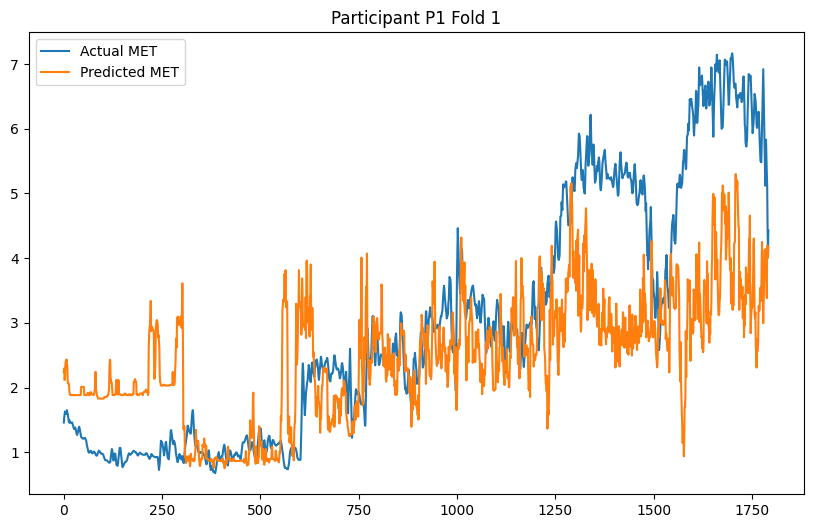

[    0     1     2 ... 27317 27318 27319] [1793 1794 1795 ... 3624 3625 3626]


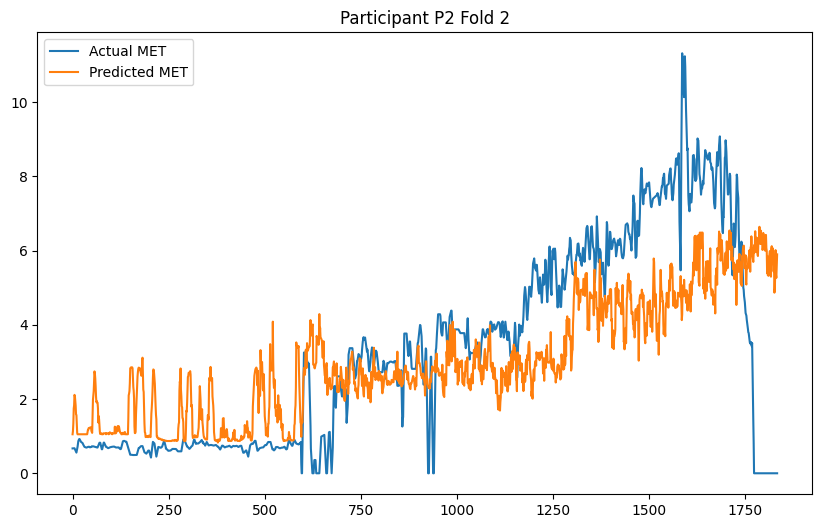

[    0     1     2 ... 27317 27318 27319] [3627 3628 3629 ... 5112 5113 5114]


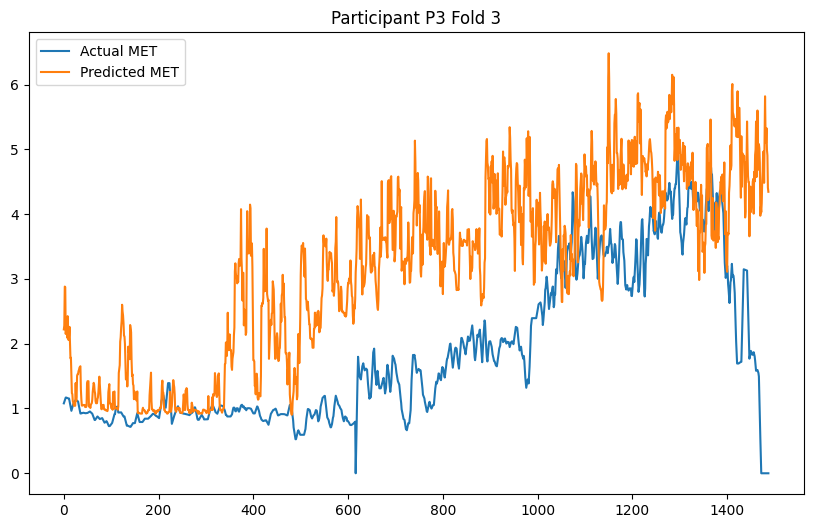

[    0     1     2 ... 27317 27318 27319] [5115 5116 5117 ... 6923 6924 6925]


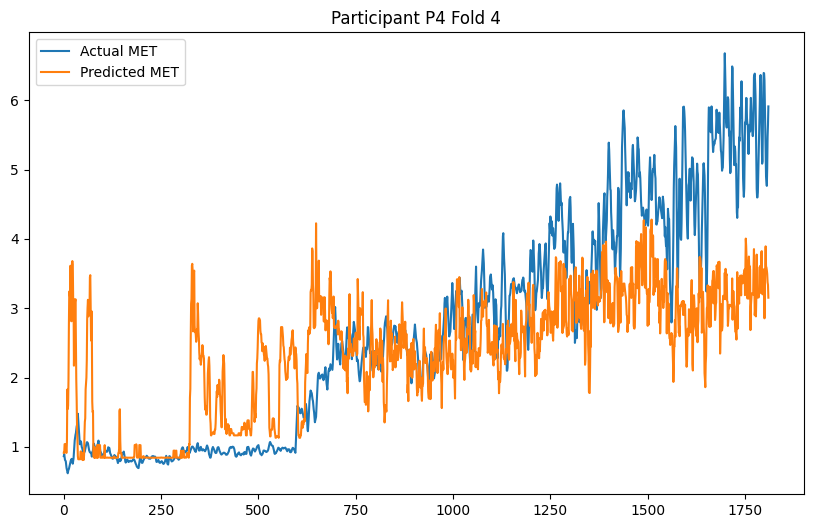

[    0     1     2 ... 27317 27318 27319] [6926 6927 6928 ... 8633 8634 8635]


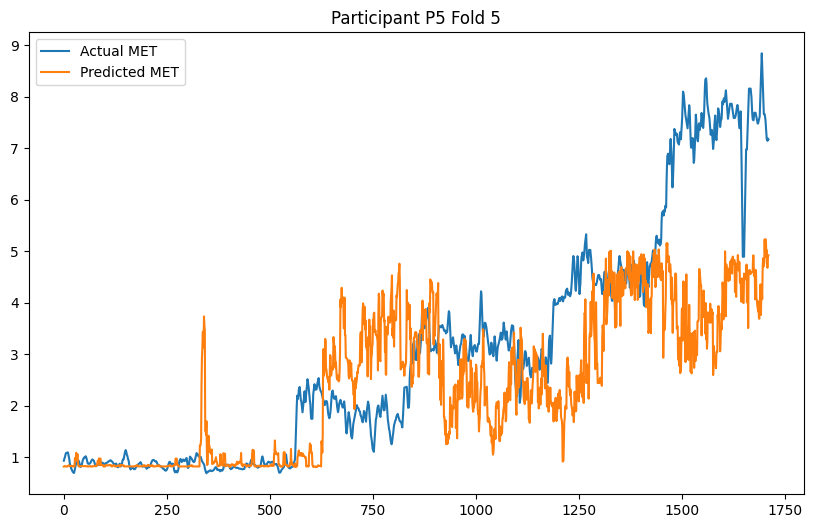

[    0     1     2 ... 27317 27318 27319] [ 8636  8637  8638 ... 10274 10275 10276]


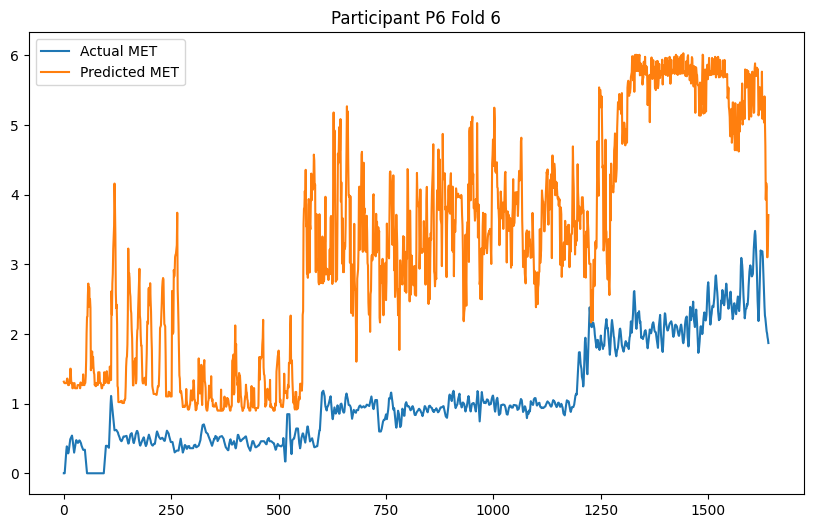

[    0     1     2 ... 27317 27318 27319] [10277 10278 10279 ... 12061 12062 12063]


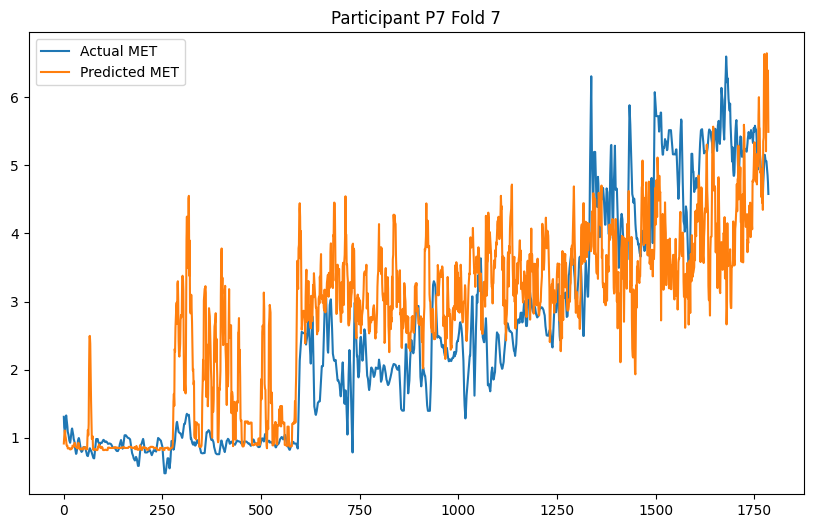

[    0     1     2 ... 27317 27318 27319] [12064 12065 12066 ... 13761 13762 13763]


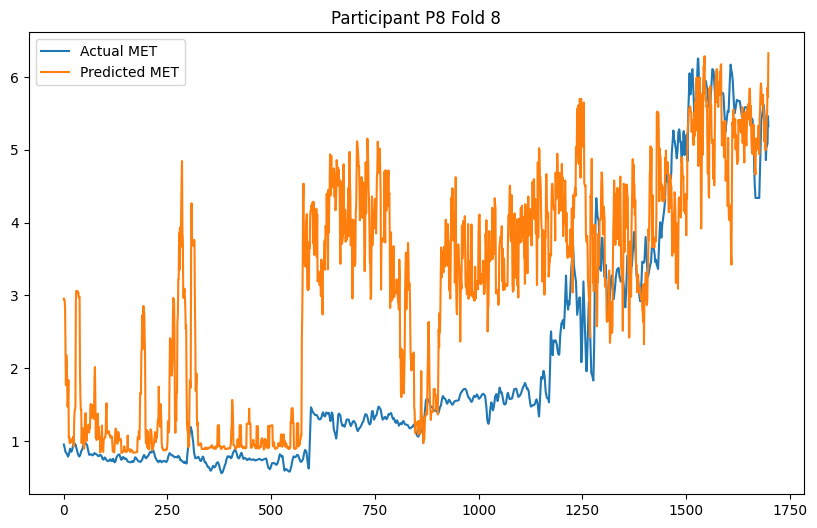

[    0     1     2 ... 27317 27318 27319] [13764 13765 13766 ... 15307 15308 15309]


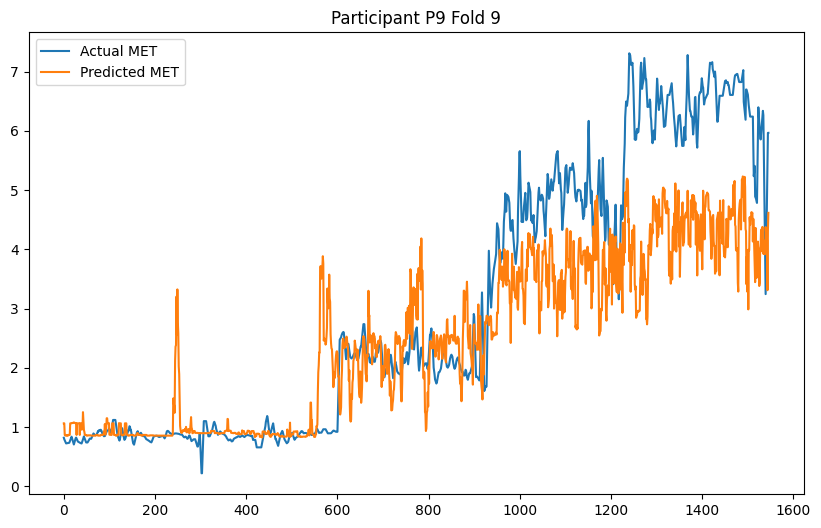

[    0     1     2 ... 27317 27318 27319] [15310 15311 15312 ... 16658 16659 16660]


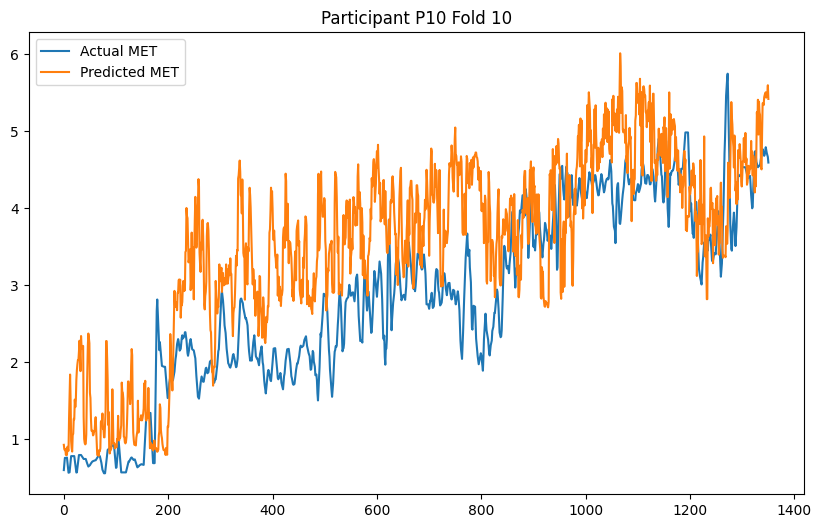

[    0     1     2 ... 27317 27318 27319] [16661 16662 16663 ... 18414 18415 18416]


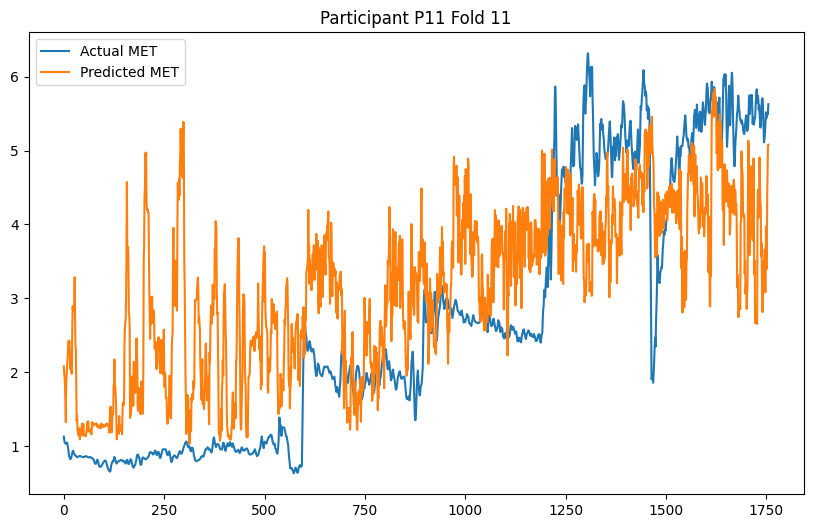

[    0     1     2 ... 27317 27318 27319] [18417 18418 18419 ... 20118 20119 20120]


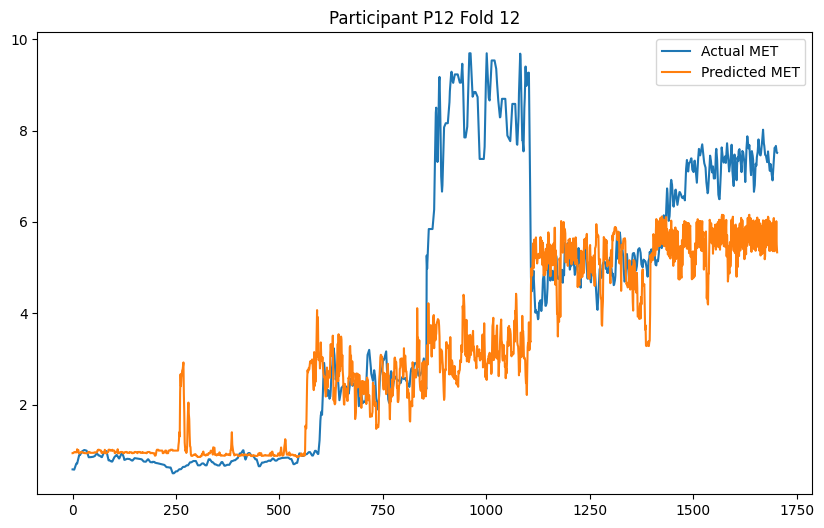

[    0     1     2 ... 27317 27318 27319] [20121 20122 20123 ... 21911 21912 21913]


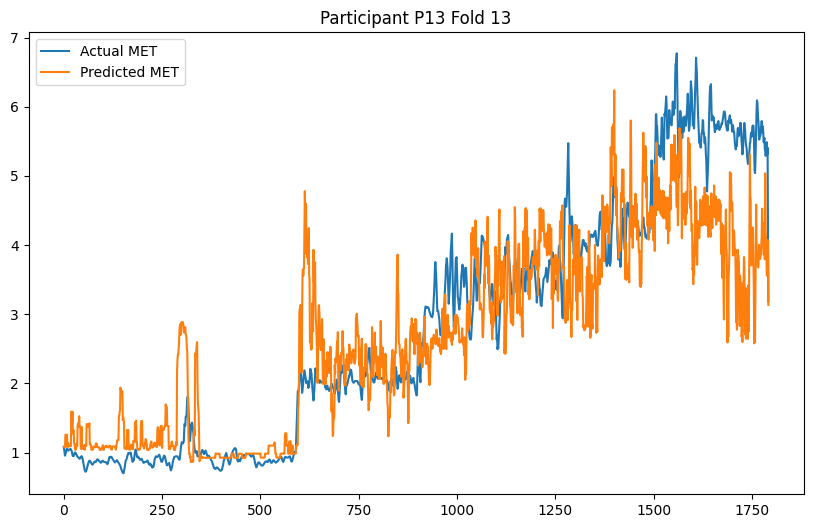

[    0     1     2 ... 27317 27318 27319] [21914 21915 21916 21917 21918 21919 21920 21921 21922 21923 21924 21925
 21926 21927 21928 21929 21930 21931 21932 21933 21934 21935 21936 21937
 21938 21939 21940 21941 21942 21943 21944 21945 21946 21947 21948 21949
 21950 21951 21952 21953 21954 21955 21956 21957 21958 21959 21960 21961
 21962 21963 21964 21965 21966 21967 21968 21969 21970 21971 21972 21973
 21974 21975 21976 21977 21978 21979 21980 21981 21982 21983 21984 21985
 21986 21987 21988 21989 21990 21991 21992 21993 21994 21995 21996 21997
 21998 21999 22000 22001 22002 22003 22004 22005 22006 22007 22008 22009
 22010 22011 22012 22013 22014 22015 22016 22017 22018 22019 22020 22021
 22022 22023 22024 22025 22026 22027 22028 22029 22030 22031 22032 22033
 22034 22035 22036 22037 22038 22039 22040 22041 22042 22043 22044 22045
 22046 22047 22048 22049 22050 22051 22052 22053 22054 22055 22056 22057
 22058 22059 22060 22061 22062 22063 22064 22065 22066 22067 22068 22069
 22070 22

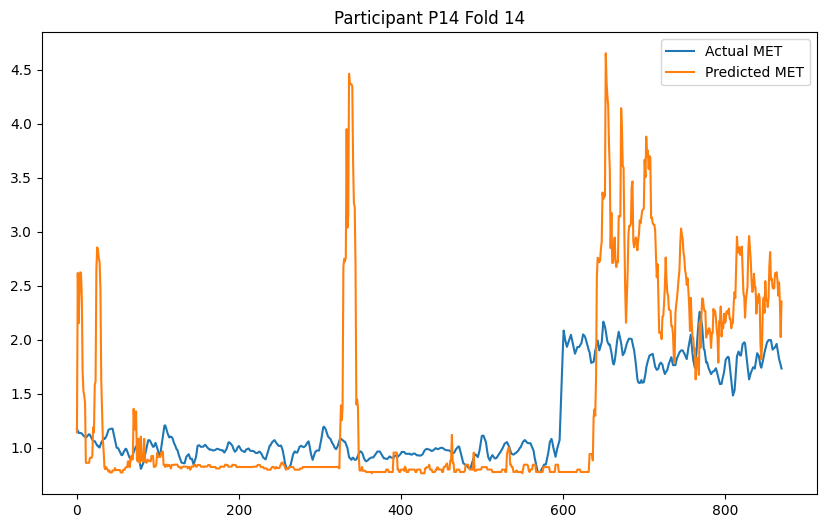

[    0     1     2 ... 27317 27318 27319] [22785 22786 22787 ... 24333 24334 24335]


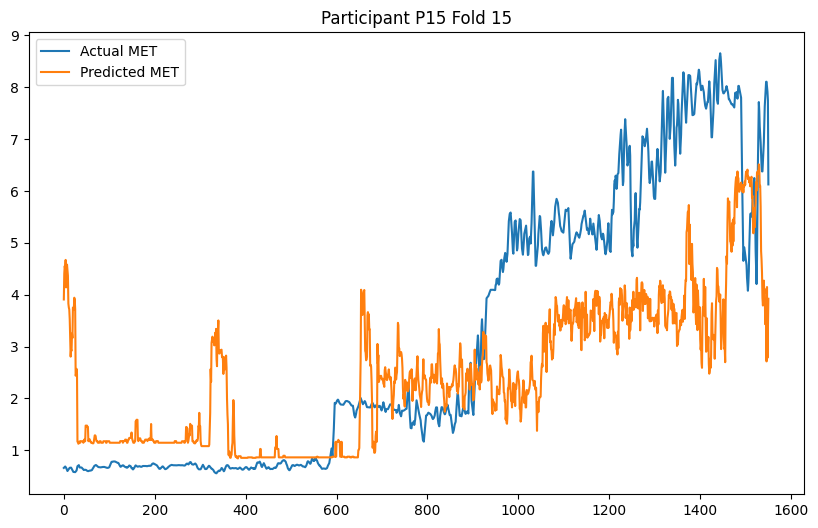

[    0     1     2 ... 27317 27318 27319] [24336 24337 24338 ... 25525 25526 25527]


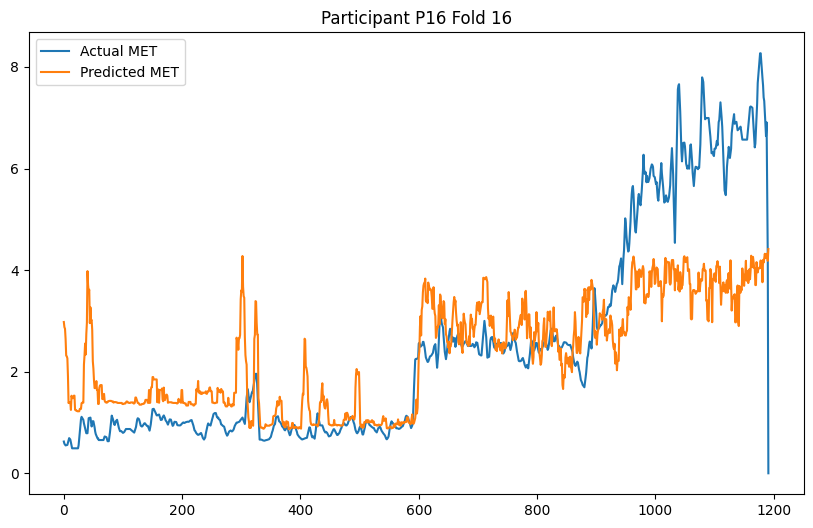

[    0     1     2 ... 25525 25526 25527] [25528 25529 25530 ... 27317 27318 27319]


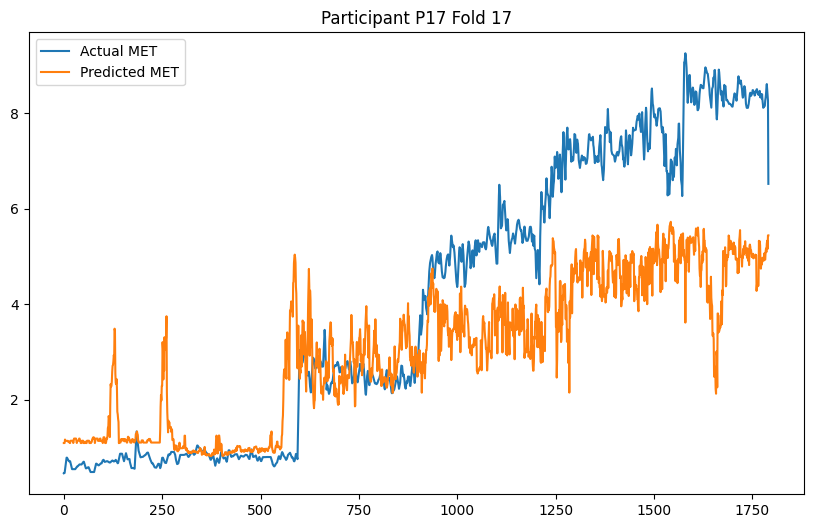

In [84]:
import matplotlib.pyplot as plt
# Import MAE
from sklearn.metrics import mean_absolute_error
# Plot the actual MET and the predicted MET for participants
cv = [split for split in group_kfold.split(X_data, Y_data, participants)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    print(train_index, test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant {0} Fold {1}'.format(participants_list[fold], fold+1))
    plt.legend()
    plt.show()